In [4]:
import matplotlib.pyplot as plt
import numpy as np
import openmm
from openmm import unit, CustomNonbondedForce

from colloids import ColloidPotentialsAlgebraic, ColloidPotentialsParameters

import math

In [116]:
radius_positive = 105.0 * unit.nanometer
radius_negative = 105.0 * unit.nanometer

#Set surface charges to 0 - using neutral particles
surface_potential_positive = 0.0 * (unit.milli * unit.volt)
surface_potential_negative = -0.0 * (unit.milli * unit.volt)

brush_length=10.0 * unit.nanometer
brush_density=0.09 / (unit.nanometer ** 2)
temperature=298.0 * unit.kelvin
box_length = 1000* unit.nanometer

colloid_potential_parameters = ColloidPotentialsParameters(
    brush_density=0.09 / (unit.nanometer ** 2), brush_length=10.0 * unit.nanometer,
    debye_length=6.0 * unit.nanometer, temperature=298.0 * unit.kelvin,
    dielectric_constant=80.0)

depletion_phi = 0.5
depletant_radius = 5.0 * unit.nanometer

In [117]:
def expected_AO_potential(r, radius_one, radius_two, brush_length, depletion_phi, depletant_radius, temperature):
    
    rho_colloid1 = radius_one + brush_length
    rho_colloid2 = radius_two + brush_length
    
    # size ratio 
    q1 = rho_colloid1/depletant_radius
    q2 = rho_colloid2/depletant_radius
    
    n = r/depletant_radius
    
    #depletion_prefactor = -depletion_phi/16 #* unit.BOLTZMANN_CONSTANT_kB * temperature
    depletion_prefactor = -(unit.BOLTZMANN_CONSTANT_kB * temperature * unit.AVOGADRO_CONSTANT_NA 
        * depletion_phi / 16.0).value_in_unit(unit.kilojoule_per_mole)
    
    return np.where(r <= (rho_colloid1 + rho_colloid2 + 2*depletant_radius),
                    depletion_prefactor*(q1+q2+2-n)**2*(n+2*(q1+q2+2)-3/n*(q1**2+q2**2-2*q1*q2)),
                    0.0)

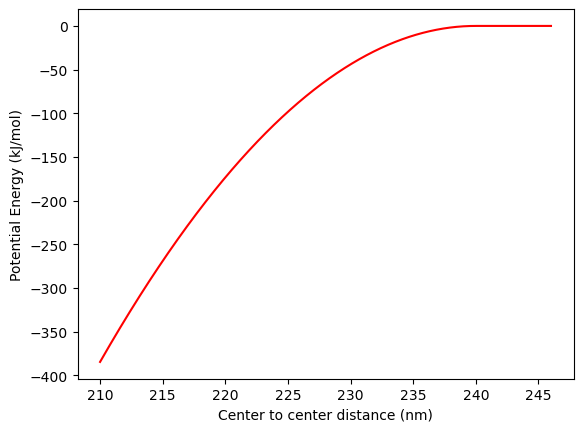

In [118]:
h_vals = np.linspace(0.0, 36.0, num=1000) * unit.nanometer

r_vals = h_vals + radius_negative + radius_positive

ao_vals_expected = expected_AO_potential(r_vals, radius_negative, radius_positive, brush_length, depletion_phi, depletant_radius, temperature)

plt.plot(r_vals, ao_vals_expected, color='red') 
#plt.ylim(-1,1)
plt.xlabel("Center to center distance (nm)")
plt.ylabel("Potential Energy (kJ/mol)")
plt.show()

In [119]:
def get_AO_potential(r_values, radius1, radius2, box_length, brush_length, depletion_phi, depletant_radius, platform_name="Reference"):
    
    system = openmm.System()

    system.setDefaultPeriodicBoxVectors([box_length, 0.0, 0.0],
                                        [0.0, box_length, 0.0],
                                        [0.0, 0.0, box_length])
    
    
    temperature = 298.0 * unit.kelvin
    
    
    depletion_potential = CustomNonbondedForce(
            "step(depletion_q1 + depletion_q2 + 2 - n) * "
            "depletion_prefactor * (depletion_q1 + depletion_q2 + 2 - n)^2 "
            "* (n + 2 * (depletion_q1 + depletion_q2 + 2) "
            "- 3.0 / n * (depletion_q1^2 + depletion_q2^2 - 2.0 * depletion_q1 * depletion_q2));"
            "n = r / depletant_radius;"
            )
    depletion_potential.addGlobalParameter(
        "depletion_prefactor",
        (-unit.BOLTZMANN_CONSTANT_kB * temperature * unit.AVOGADRO_CONSTANT_NA
         * depletion_phi / 16.0).value_in_unit(unit.kilojoule_per_mole))
    depletion_potential.addGlobalParameter("depletant_radius",
                                           depletant_radius)
    depletion_potential.addPerParticleParameter("depletion_q")
    
    
    system.addParticle(mass=1.0)
    depletion_potential.addParticle([(radius1 + brush_length) /depletant_radius])
    system.addParticle(mass=1.0)
    depletion_potential.addParticle([(radius2 + brush_length) /depletant_radius])
    
    # Add forces.
    system.addForce(depletion_potential)
        
    for force in system.getForces():
        print(f"Energy function: {force.getEnergyFunction()}")
    
    # Set up platform and context. The platform_name is typically Reference or CUDA.
    platform = openmm.Platform.getPlatformByName(platform_name)
    dummy_integrator = openmm.LangevinIntegrator(
        temperature, 0.0, 0.0)
    context = openmm.Context(system, dummy_integrator, platform)
    print(f"Using {context.getPlatform().getName()} platform.")
    if context.getPlatform().getName() == "CUDA":
        for cuda_property in ("Precision", "TempDirectory", "UseCpuPme", "DeviceIndex", "UseBlockingSync", "DeterministicForces"):
            print(f"{cuda_property}: {context.getPlatform().getPropertyValue(context, cuda_property)}")
    
    
    potential_energies = np.zeros(len(r_values))
    for r_index, r_value in enumerate(r_values):
        #context.setPositions([[r_value*unit.nanometer-2*brush_length, 0.0, 0.0], [0.0, 0.0, 0.0]])
        context.setPositions([[r_value*unit.nanometer, 0.0, 0.0], [0.0, 0.0, 0.0]])
        state = context.getState(getEnergy=True)
        potential_energies[r_index] = (
            state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
            #/ (unit.BOLTZMANN_CONSTANT_kB *temperature * unit.AVOGADRO_CONSTANT_NA)
        )
    
    return potential_energies
    

Energy function: step(depletion_q1 + depletion_q2 + 2 - n) * depletion_prefactor * (depletion_q1 + depletion_q2 + 2 - n)^2 * (n + 2 * (depletion_q1 + depletion_q2 + 2) - 3.0 / n * (depletion_q1^2 + depletion_q2^2 - 2.0 * depletion_q1 * depletion_q2));n = r / depletant_radius;
Using Reference platform.


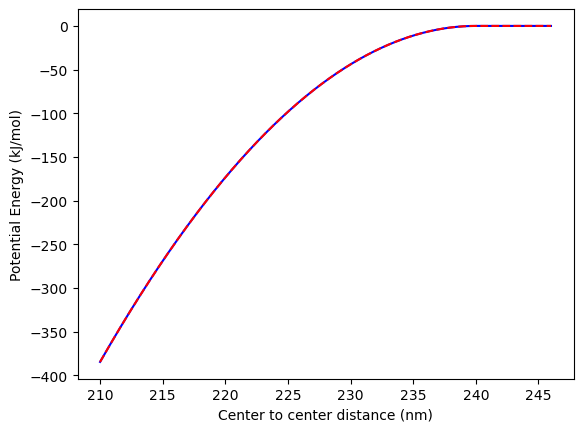

In [120]:
# check that numpy and openmm functions give same output

ao_vals = get_AO_potential(r_vals, radius_negative, radius_positive, box_length, brush_length, depletion_phi, depletant_radius)

plt.plot(r_vals, ao_vals, color='blue')
plt.plot(r_vals, ao_vals_expected, color='red', linestyle='--')
plt.xlabel("Center to center distance (nm)")
plt.ylabel("Potential Energy (kJ/mol)")
plt.show()

In [121]:
# get steric and electrostatic potentials
# the electrostatic potential will be zero because particles are not charged

def get_potentials(h_values, radius_one, radius_two, surface_potential_one, surface_potential_two, 
                   parameters, platform_name="Reference"):
    # Set up system.
    system = openmm.System()
    # Make system very large so that we do not care about periodic boundaries.
    system.setDefaultPeriodicBoxVectors([1000.0, 0.0, 0.0],
                                        [0.0, 1000.0, 0.0],
                                        [0.0, 0.0, 1000.0])
    colloid_potentials = ColloidPotentialsAlgebraic(
        colloid_potentials_parameters=parameters, use_log=False)
    
    # Add two particles to the system and forces (mass is unimportant for the potential energies).
    system.addParticle(mass=1.0)
    colloid_potentials.add_particle(radius=radius_one, surface_potential=surface_potential_one)
    system.addParticle(mass=1.0)
    colloid_potentials.add_particle(radius=radius_two, surface_potential=surface_potential_two)

    # Add forces.
    for potential in colloid_potentials.yield_potentials():
        system.addForce(potential)
        
    for force in system.getForces():
        print(f"Energy function: {force.getEnergyFunction()}")
        print(f"Nonbonded method: {force.getNonbondedMethod()}, Cutoff distance: {force.getCutoffDistance()}")
        assert force.usesPeriodicBoundaryConditions()
        assert not force.getUseLongRangeCorrection()
    
    # Set up platform and context. The platform_name is typically Reference or CUDA.
    platform = openmm.Platform.getPlatformByName(platform_name)
    dummy_integrator = openmm.LangevinIntegrator(
        parameters.temperature.value_in_unit(unit.kelvin), 0.0, 0.0)
    context = openmm.Context(system, dummy_integrator, platform)
    print(f"Using {context.getPlatform().getName()} platform.")
    if context.getPlatform().getName() == "CUDA":
        for cuda_property in ("Precision", "TempDirectory", "UseCpuPme", "DeviceIndex", "UseBlockingSync", "DeterministicForces"):
            print(f"{cuda_property}: {context.getPlatform().getPropertyValue(context, cuda_property)}")
    
    
    potential_energies = np.zeros(len(h_values))
    for h_index, h_value in enumerate(h_values):
        context.setPositions([[radius_one + radius_two + h_value, 0.0, 0.0], [0.0, 0.0, 0.0]])
        state = context.getState(getEnergy=True)
        potential_energies[h_index] = (
            state.getPotentialEnergy()
            / (unit.BOLTZMANN_CONSTANT_kB * parameters.temperature * unit.AVOGADRO_CONSTANT_NA)
        )
    
    return potential_energies

Energy function: step(two_l - h) * steric_prefactor * rs / 2.0 * brush_length * brush_length * (28.0 * ((two_l / h)^0.25 - 1.0) + 20.0 / 11.0 * (1.0 - (h / two_l)^2.75)+ 12.0 * (h / two_l - 1.0)); h = r - rs;rs = radius1 + radius2;two_l = 2.0 * brush_length
Nonbonded method: 2, Cutoff distance: 230.00000000000006 nm
Energy function: electrostatic_prefactor * radius * psi1 * psi2 * exp(-h / debye_length); radius = 2.0 / (1.0 / radius1 + 1.0 / radius2);h = r - rs;rs = radius1 + radius2
Nonbonded method: 2, Cutoff distance: 336.0000000000001 nm
Using Reference platform.


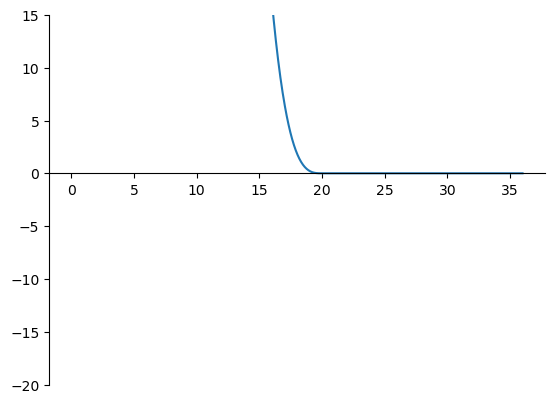

In [122]:
#plot steric and electrostatic potentials

potential_vals = get_potentials(h_vals, radius_positive, radius_negative, 
                                surface_potential_positive, surface_potential_negative,
                                colloid_potential_parameters)

plt.figure()
plt.plot(h_vals, potential_vals)
plt.ylim(-20, 15)

ax = plt.gca()
ax.spines["bottom"].set_position("zero")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
plt.show()
plt.close()

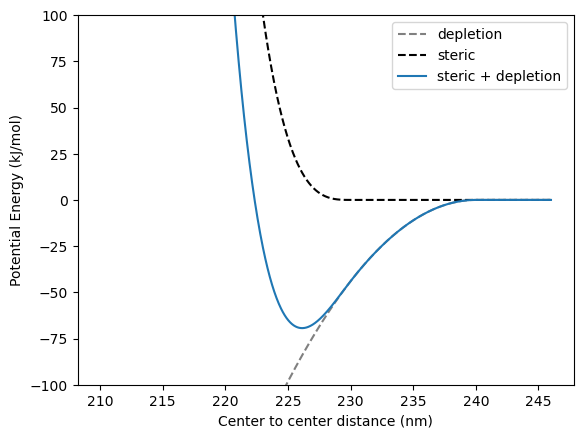

In [131]:
# plot steric and electrosatic + depletion

plt.plot(r_vals, ao_vals, label = 'depletion', ls = '--', color='gray') 
plt.plot(r_vals, potential_vals, label = 'steric', ls= '--', color='black') 

plt.plot(r_vals, ao_vals + potential_vals, label = 'steric + depletion') 
plt.ylim(-100,100)
plt.xlabel("Center to center distance (nm)")
plt.ylabel("Potential Energy (kJ/mol)")
plt.legend()
plt.show()

In [137]:
# functional form for a system with only one size colloidal particle

def expected_AO_potential_uniform(r, radius_colloid, brush_length, depletion_phi, depletant_radius, temperature):

    #diameters 
    sigma_colloid = (2 * radius_colloid + 2*brush_length) #*unit.nanometer

    sigma_depletant = (2 * depletant_radius) #+ 2*brush_length) #*unit.nanometer

    # size ratio 
    q = sigma_depletant/sigma_colloid 
    
    depletion_prefactor = -(depletion_phi * (1+q)**3/q**3 * unit.BOLTZMANN_CONSTANT_kB * temperature * unit.AVOGADRO_CONSTANT_NA).value_in_unit(unit.kilojoule_per_mole)

    term1 = 3*r / (2 * sigma_colloid * (1+q))

    term2 = r**3 / (2 * sigma_colloid**3 *(1+q)**3)
    
    return np.where(r <= (sigma_colloid + sigma_depletant),
                    (depletion_prefactor * (1 - term1 + term2)),
                    0.0) 

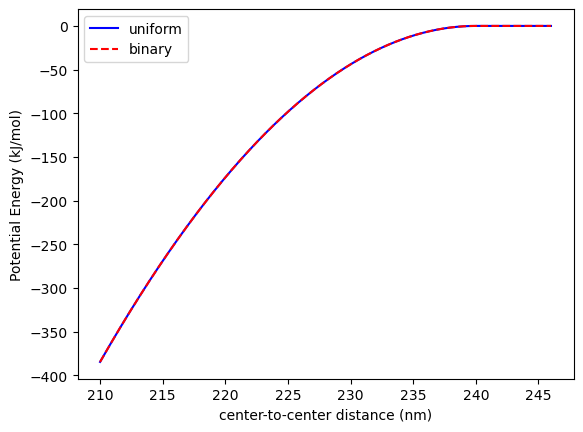

In [138]:
# set radii the same to check that binary and uniform functions become identical 

radius_positive = 105.0 * unit.nanometer
radius_negative = 105.0 * unit.nanometer

ao_vals_expected1 = expected_AO_potential_uniform(r_vals, radius_negative, brush_length, depletion_phi, depletant_radius, temperature)
 
ao_vals_expected2 = expected_AO_potential(r_vals, radius_negative, radius_positive, brush_length, depletion_phi, depletant_radius, temperature)

plt.plot(r_vals, ao_vals_expected1, color='blue', label = 'uniform') 
plt.plot(r_vals, ao_vals_expected2, color='red', label = 'binary', ls='--' ) 

plt.xlabel("center-to-center distance (nm)")
plt.ylabel("Potential Energy (kJ/mol)")
plt.legend()
plt.show()